'''
@Author: Naziya
@Date: 2021-09-06
@Last Modified by: Naziya
@Last Modified : 2021-09-06
@Title : Program Aim is to create a dataframe from cpu log data csv file using pyspark an perform the follwing operations and also visualize the result.
1) Display users and their record counts
2) Finding users with highest number of average hours
3) Finding users with lowest number of average hours
4) Finding users with highest numbers of idle hours
5) Visualisation
'''


In [104]:
from pyspark.sql import *
from pyspark.sql import functions as F
from pyspark.sql.functions import *
spark = SparkSession.builder.getOrCreate()

In [105]:
df = spark.read.csv("hdfs://localhost:9000/spark_sql/merged.csv",header=True)
df2 =df.select("user_name","DateTime","keyboard","mouse")

In [106]:
df2.head(4)

[Row(user_name='rahilstar11@gmail.com', DateTime='2019-09-16 12:55:03', keyboard='0.0', mouse='0.0'),
 Row(user_name='salinabodale73@gmail.com', DateTime='2019-09-16 12:55:02', keyboard='2919.5', mouse='888.0'),
 Row(user_name='bhagyashrichalke21@gmail.com', DateTime='2019-09-16 12:55:01', keyboard='144.0', mouse='2886.0'),
 Row(user_name='bhagyashrichalke21@gmail.com', DateTime='2019-09-16 13:00:01', keyboard='21.0', mouse='44.0')]

 1) Display users and their record counts

In [107]:

dfc = df2.groupby("user_name").count()

In [108]:
dfc.show()

+--------------------+-----+
|           user_name|count|
+--------------------+-----+
|salinabodale73@gm...|  569|
|sharlawar77@gmail...|  580|
|rahilstar11@gmail...|  551|
|deepshukla292@gma...|  565|
|  iamnzm@outlook.com|  614|
|markfernandes66@g...|  508|
|damodharn21@gmail...|  253|
|bhagyashrichalke2...|  482|
|           user_name|    5|
+--------------------+-----+



 2) Finding users with highest number of average hours

In [109]:
df.createOrReplaceTempView("view1")
df1 = spark.sql("SELECT user_name from view1 WHERE keyboard !=0 OR mouse !=0").groupby("user_name").count()
df1.show(truncate=False)

+----------------------------+-----+
|user_name                   |count|
+----------------------------+-----+
|salinabodale73@gmail.com    |436  |
|sharlawar77@gmail.com       |457  |
|rahilstar11@gmail.com       |399  |
|deepshukla292@gmail.com     |475  |
|iamnzm@outlook.com          |459  |
|markfernandes66@gmail.com   |389  |
|damodharn21@gmail.com       |191  |
|bhagyashrichalke21@gmail.com|361  |
+----------------------------+-----+



In [110]:
df3 = df1.createOrReplaceTempView("hour_view")

In [111]:
df4 = spark.sql("SELECT user_name,count,((((count-1)*5)*60)/6) as avg_secs from hour_view")

In [112]:
df4.show(truncate=False)

+----------------------------+-----+--------+
|user_name                   |count|avg_secs|
+----------------------------+-----+--------+
|salinabodale73@gmail.com    |436  |21750.0 |
|sharlawar77@gmail.com       |457  |22800.0 |
|rahilstar11@gmail.com       |399  |19900.0 |
|deepshukla292@gmail.com     |475  |23700.0 |
|iamnzm@outlook.com          |459  |22900.0 |
|markfernandes66@gmail.com   |389  |19400.0 |
|damodharn21@gmail.com       |191  |9500.0  |
|bhagyashrichalke21@gmail.com|361  |18000.0 |
+----------------------------+-----+--------+



In [113]:
from pyspark.sql.functions import *
highest_average_hour = df4.withColumn("highest_average_hours", concat(
            floor(col("avg_secs") % 86400 / 3600), lit(":"),
            floor((col("avg_secs") % 86400) % 3600 / 60), lit(""),
        ))

In [114]:
highest_average_hour.show(truncate=False)

+----------------------------+-----+--------+---------------------+
|user_name                   |count|avg_secs|highest_average_hours|
+----------------------------+-----+--------+---------------------+
|salinabodale73@gmail.com    |436  |21750.0 |6:2                  |
|sharlawar77@gmail.com       |457  |22800.0 |6:20                 |
|rahilstar11@gmail.com       |399  |19900.0 |5:31                 |
|deepshukla292@gmail.com     |475  |23700.0 |6:35                 |
|iamnzm@outlook.com          |459  |22900.0 |6:21                 |
|markfernandes66@gmail.com   |389  |19400.0 |5:23                 |
|damodharn21@gmail.com       |191  |9500.0  |2:38                 |
|bhagyashrichalke21@gmail.com|361  |18000.0 |5:0                  |
+----------------------------+-----+--------+---------------------+



 3) Finding users with lowest number of average hours

In [122]:
from pyspark.sql.functions import *
lowest_average_hour = df4.withColumn("lowest_average_hours", concat(
            floor(col("avg_secs") % 86400 / 3600), lit(":"),
            floor((col("avg_secs") % 86400) % 3600 / 60), lit(""),
        )).sort(asc('lowest_average_hours'))

In [123]:
lowest_average_hour.show()

+--------------------+-----+--------+--------------------+
|           user_name|count|avg_secs|lowest_average_hours|
+--------------------+-----+--------+--------------------+
|damodharn21@gmail...|  191|  9500.0|                2:38|
|bhagyashrichalke2...|  361| 18000.0|                 5:0|
|markfernandes66@g...|  389| 19400.0|                5:23|
|rahilstar11@gmail...|  399| 19900.0|                5:31|
|salinabodale73@gm...|  436| 21750.0|                 6:2|
|sharlawar77@gmail...|  457| 22800.0|                6:20|
|  iamnzm@outlook.com|  459| 22900.0|                6:21|
|deepshukla292@gma...|  475| 23700.0|                6:35|
+--------------------+-----+--------+--------------------+



 4) Finding users with highest numbers of idle hours

In [124]:
df5 = spark.sql("SELECT user_name FROM view1 WHERE keyboard == 0 and mouse == 0 ").groupBy("user_name").count()
df5.show()

+--------------------+-----+
|           user_name|count|
+--------------------+-----+
|salinabodale73@gm...|  133|
|sharlawar77@gmail...|  123|
|rahilstar11@gmail...|  152|
|deepshukla292@gma...|   90|
|  iamnzm@outlook.com|  155|
|markfernandes66@g...|  119|
|damodharn21@gmail...|   62|
|bhagyashrichalke2...|  121|
+--------------------+-----+



In [125]:
df5.createOrReplaceTempView('idle_hour_view')

In [126]:
df6 = spark.sql("SELECT user_name,count,((((count-1)*5)*60)/6) as average_min from idle_hour_view")

In [127]:
df6.show(truncate=False)

+----------------------------+-----+-----------+
|user_name                   |count|average_min|
+----------------------------+-----+-----------+
|salinabodale73@gmail.com    |133  |6600.0     |
|sharlawar77@gmail.com       |123  |6100.0     |
|rahilstar11@gmail.com       |152  |7550.0     |
|deepshukla292@gmail.com     |90   |4450.0     |
|iamnzm@outlook.com          |155  |7700.0     |
|markfernandes66@gmail.com   |119  |5900.0     |
|damodharn21@gmail.com       |62   |3050.0     |
|bhagyashrichalke21@gmail.com|121  |6000.0     |
+----------------------------+-----+-----------+



In [128]:
from pyspark.sql.functions import *
idle_hour = df6.withColumn("idle_hours", concat(
            floor(col("average_min") % 86400 / 3600), lit(":"),
            floor((col("average_min") % 86400) % 3600 / 60), lit(""),
        ))

In [129]:
idle_hour.show(truncate=False)


+----------------------------+-----+-----------+----------+
|user_name                   |count|average_min|idle_hours|
+----------------------------+-----+-----------+----------+
|salinabodale73@gmail.com    |133  |6600.0     |1:50      |
|sharlawar77@gmail.com       |123  |6100.0     |1:41      |
|rahilstar11@gmail.com       |152  |7550.0     |2:5       |
|deepshukla292@gmail.com     |90   |4450.0     |1:14      |
|iamnzm@outlook.com          |155  |7700.0     |2:8       |
|markfernandes66@gmail.com   |119  |5900.0     |1:38      |
|damodharn21@gmail.com       |62   |3050.0     |0:50      |
|bhagyashrichalke21@gmail.com|121  |6000.0     |1:40      |
+----------------------------+-----+-----------+----------+



Visualization

Bar plot for user and count record

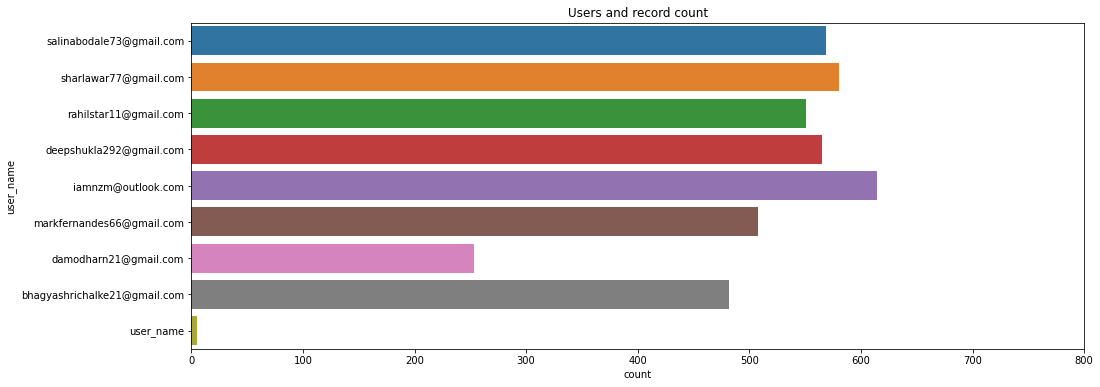

In [130]:
from LoggerFormat import logger
from matplotlib import pyplot as plt
import seaborn as sns

try:
    dfb = dfc.toPandas()
    plt.figure(figsize = (16,6))
    sns.barplot(x = 'count', y='user_name',data = dfb)
    plt.xlim(0,800)
    plt.title('Users and record count')
    plt.show()
except Exception as err:
    logger.error(err)

Pie plot for user and count record

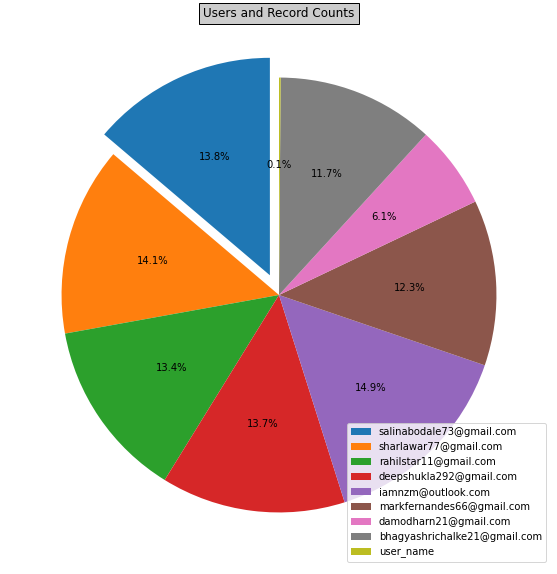

In [132]:
from matplotlib import pyplot as plt 
import pandas as pd
from LoggerFormat import logger

try:
    
    df =  dfc.toPandas()
    user_data = df["user_name"]
    count_data = df["count"]

    fig = plt.figure(figsize=(10,10))
    fig.patch.set_facecolor('w')
    explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0)
    plt.pie(count_data,autopct='%1.1f%%',startangle=90,explode=explode,)
    plt.title('Users and Record Counts',bbox={'facecolor':'0.8', 'pad':4})
    plt.legend(user_data)
   

except Exception as e:
    logger.error(e)

Bar plot for average hours by users

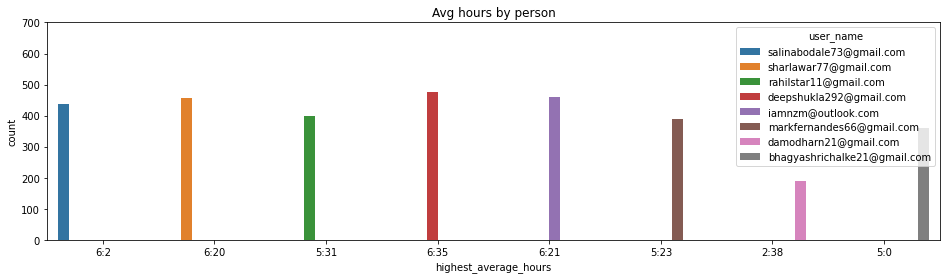

In [133]:
import seaborn as sns
from LoggerFormat import logger
from matplotlib import pyplot as plt

try:
    df = highest_average_hour.toPandas()
    plt.figure(figsize = (16,4))
    sns.barplot(x = 'highest_average_hours', y='count', data = df, hue ='user_name')
    plt.title("Avg hours by person")
    plt.ylim(0,700)
    plt.show()
except Exception as err:
    logger.error(err)



Bar plot for idle hours and count

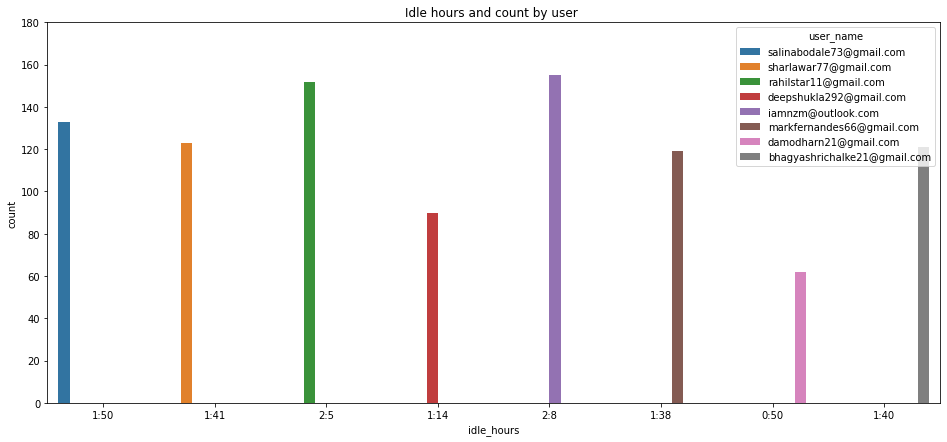

In [134]:
from LoggerFormat import logger
from matplotlib import pyplot as plt
import seaborn as sns

try:
    df = idle_hour.toPandas()
    plt.figure(figsize = (16,7))
    sns.barplot(x = 'idle_hours',y='count',data = df, hue ='user_name')
    plt.title("Idle hours and count by user ")
    plt.ylim(0,180)
    plt.show()
except Exception as err:
    logger.error(err)

Pie plot for idle hours

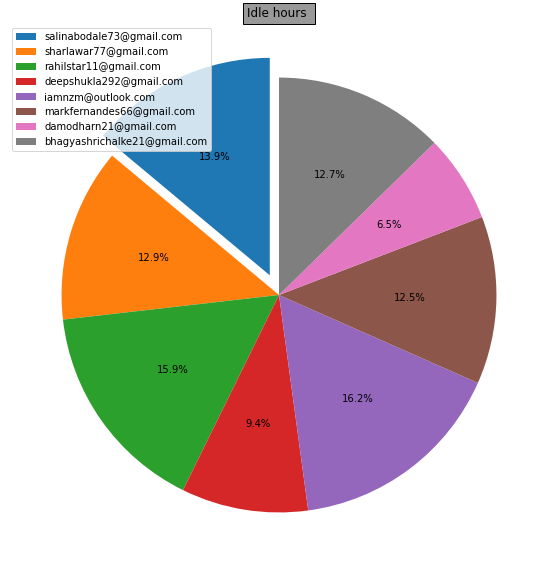

In [135]:
from matplotlib import pyplot as plt 
import pandas as pd
from LoggerFormat import logger

try:
    df =  idle_hour.toPandas()
    user_data = df["user_name"]
    count_data = df["count"]

    fig = plt.figure(figsize=(10,10))
    fig.patch.set_facecolor('w')
    explode = (0.1, 0, 0, 0, 0, 0, 0, 0)
    # Plot
    plt.pie(count_data,autopct='%1.1f%%',startangle=90,explode=explode,)
    plt.title("Idle hours ",bbox={'facecolor':'0.6', 'pad':4})
    plt.legend(user_data)
   

except Exception as e:
    logger.error(e)